# Profile fitting

$\mathrm{LiMe}$ provides two kind of line flux measurements. The first one is a integrated pixel (``intg_flux`` and ``intg_flux_err`` on the measurements file) flux integration via a Monte-Carlo  (``profile_flux`` and ``profile_flux_err`` on the measurements file). The second type is derived by fitting a profile to the observed line. For example:

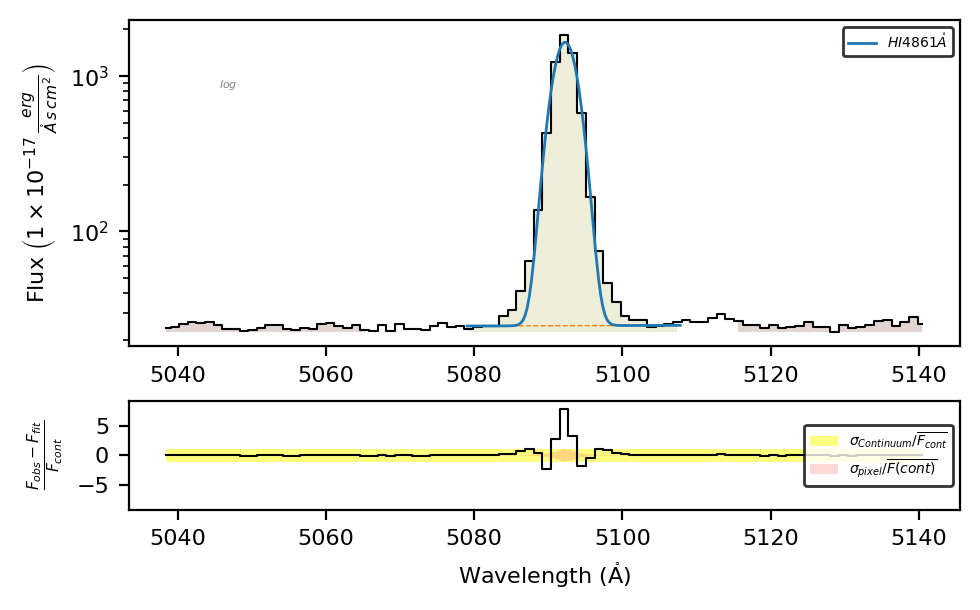

In [56]:
from pathlib import Path
import lime

# Specify the data location the observations
data_folder = Path('../sample_data')
sloan_SHOC579 = data_folder/'spectra'/'sdss_dr18_0358-51818-0504.fits'
bands_df_file = daSHOC579ta_folder/'SHOC579_bands.txt'

# Create the observation object
spec = lime.Spectrum.from_file(sloan_SHOC579, instrument='sdss', redshift=0.0475)

# Fit a line from the default label list
spec.fit.bands('H1_4861A')

# Plot the measurement
spec.plot.bands()

In the fitting above, we just introduced the default line label for $H\beta$ from the line database database and this will provide us with the default bands. 

The output measurements can be found on the frame attribute. Since this ``frame`` is a [pandas dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame). It's can be accessed as:

In [57]:
spec.frame[['profile_flux', 'profile_flux_err', 'amp', 'center', 'sigma']]

,profile_flux,profile_flux_err,amp,center,sigma
H1_4861A,6384.145433,252.411349,1633.060999,5092.268679,1.559386


## Multi-profile fitting

The approach above is good enought to measure single profile lines. However, in the case of blended profiles:

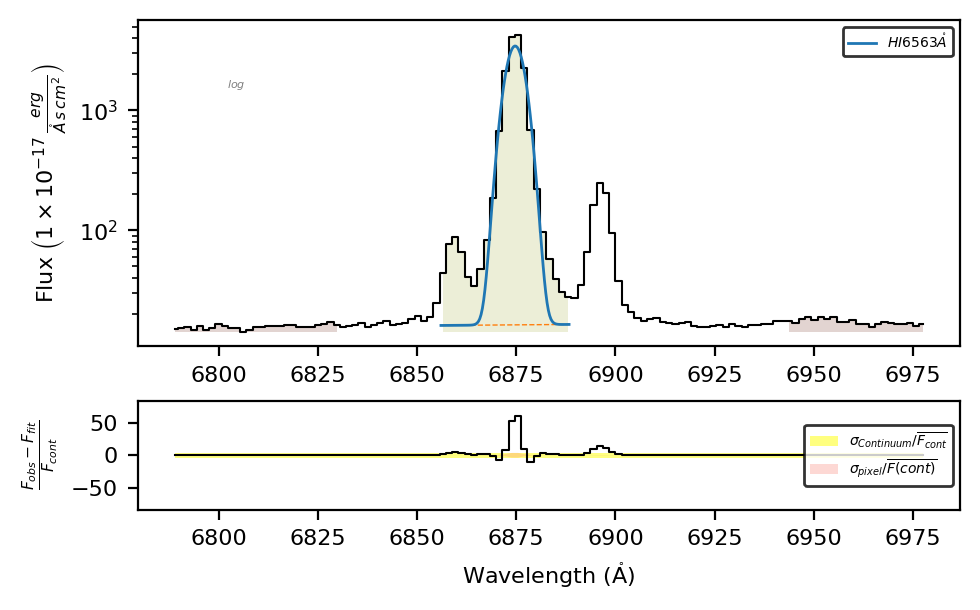

In [58]:
# Fit a line from the default label list
spec.fit.bands('H1_6563A')
spec.plot.bands()

the fitting does not reproduce well the emission. 

A better approach is to fit all the components simultaneously. Let's start by making a wider band for $H\alpha$ and the $[NII]6548,6584\mathring{A}$ choosing a wider band:

In [59]:
band_df = spec.retrieve.line_bands(line_list=['H1_6563A'], band_vsigma=350)
band_df

,wavelength,wave_vac,w1,w2,w3,w4,w5,w6,latex_label,units_wave,particle,transition,rel_int
H1_6563A,6562.7192,6564.632,6480.03,6520.66,6529.507686,6595.930714,6627.7,6661.82,$HI6563\mathring{A}$,Angstrom,H1,rec,1.0


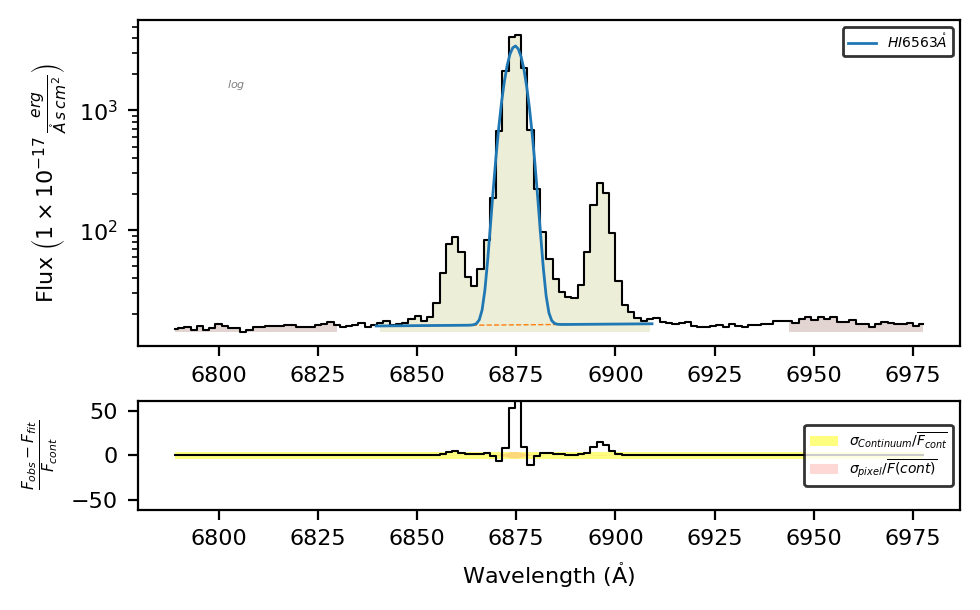

In [60]:
spec.fit.bands('H1_6563A', bands=band_df)
spec.plot.bands()

Now the central ban covvers the three transitions. However, only one line was fitted. To fit the three profile we need to specify the blended profile and its components:

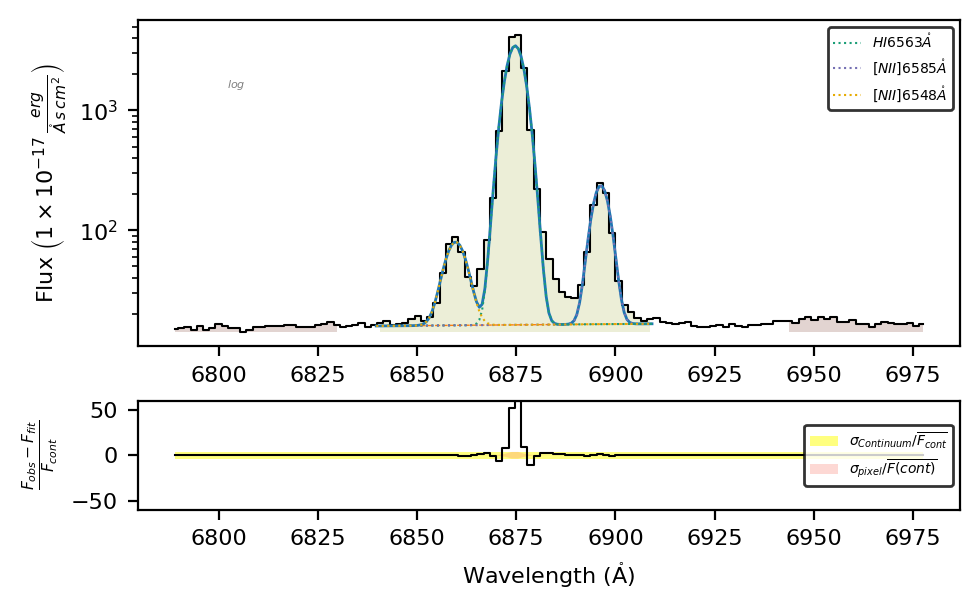

In [61]:
fit_cfg = {'H1_6563A_b': 'H1_6563A+N2_6585A+N2_6548A'}
spec.fit.bands('H1_6563A_b', band_df, fit_cfg)
spec.plot.bands()

In this case, we have succesfully fitted the three components by adjusting the following inputs:
 * The input line label now has the blended suffix **(_b)** suffix
 * We introduced a fitting configuration dicionary with the components of the profile. In this notation, **the individual components use $\mathrm{LiMe}$ notation joined by a "+"**

## Constrain the profile parameters

By default, $\mathrm{LiMe}$ fits a Gaussian profile. The mathematical expression for this profile is:

$\mathrm{F_{\lambda}=\sum_{i}A_{i}e^{-\left(\frac{\lambda-\mu_{i}}{2\sigma_{i}}\right)^{2}} + m{\lambda} + c}$

In $\mathrm{LiMe}$, these parameters are named using the line label as prefix so for the previous fitting we would have:
 * $\tt{H1\_6563A\_amp}$: is the line amplitude the height of the Gaussian from the continuum $(A_i)$. 
 * $\tt{H1\_6563A\_center}$: the wavelength of the Gaussian central observed wavelength in the spectrum wavelength units $(\mu_i)$.
 * $\tt{H1\_6563A\_sigma}$: the width of the Gaussian curve in the spectrum wavelength units $(\sigma_i)$.
 * $\tt{H1\_6563A\_cont\_slope}$: the local continuum gradient. In blended lines, there is only one continuum labeled after the first component $(m)$.
 * $\tt{H1\_6563A\_cont\_intercept}$:the linear flux at zero wavelength for the local continuum. In blended lines there is still only one continuum intercept labeled after the first component.

<div class="alert alert-info">

**Please remember:** Any value for the ``_center`` wavelength must be introduced in the rest frame, $\mathrm{LiMe}$ will add the redshift correction. Similarly, the ``_amp`` values must be on the same units as the input flux and $\mathrm{LiMe}$ will add the normalization.
</div>

The previous fitting is reasonably good. However, by constraining the lines Gaussian parameters we can improve the fitting. These constrains are applied via the attriutes of the [LmFIT parameters](https://lmfit.github.io/lmfit-py/parameters.html):

* ``value``: Initial value for the parameter. $\mathrm{LiMe}$ provides an initial guess for the parameters from
  the [integrated measurements](https://lime-stable.readthedocs.io/en/latest/documentation/measurements.html#integrated-properties).
* ``vary``: Whether the parameter is free during the fitting (default is True). If set to *False* the initial ``value`` will remain unchanged.
* ``min``: Lower bound for the parameter value. The default is value is -numpy.inf (no lower bound).
* ``max``: Upper bound for the parameter value. The default is value is numpy.inf (no upper bound).
* ``expr``: Mathematical expression to constrain the value during the fit. The default value is None.

Applying these constrains:

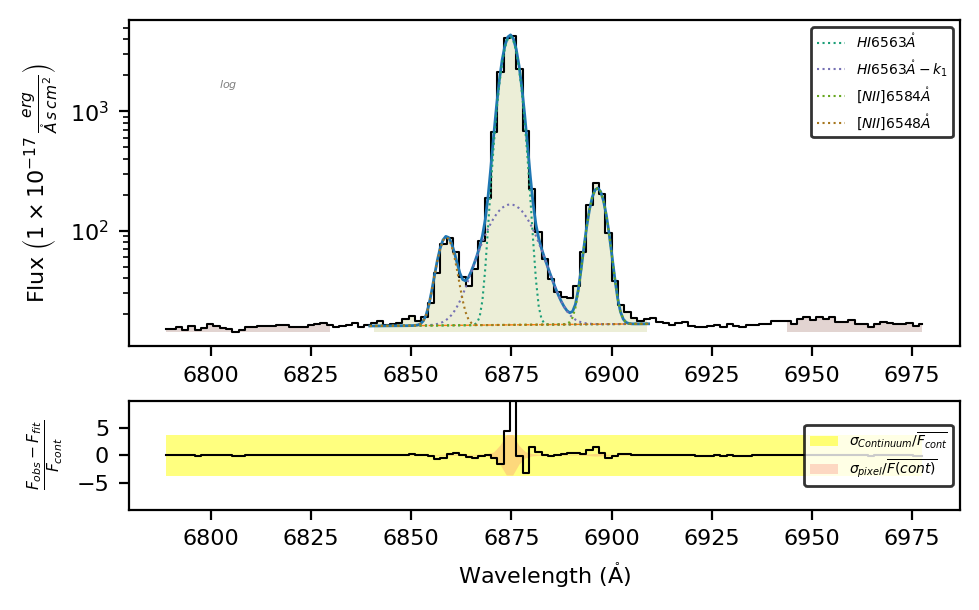

In [62]:
line = 'H1_6563A_b'
fit_conf = {'H1_6563A_b': 'H1_6563A+H1_6563A_k-1+N2_6584A+N2_6548A',        # Line components of the line
            'N2_6548A_amp': {'expr': 'N2_6584A_amp/2.94'},                  # [NII] amplitude constrained by emissivity ratio
            'N2_6548A_kinem': 'N2_6584A',                                   # Tie the kinematics of the [NII] doublet
            'H1_6563A_k-1_center': {'value':6562, 'min': 6561, 'max':6563}, # Range for the wide Hα value
            'H1_6563A_k-1_sigma': {'expr':'>1.0*H1_6563A_sigma'}}           # Second Hα sigma must be higher than first sigma

# Second attempt including the fit configuration
spec.fit.bands(line, band_df, fit_conf)
spec.plot.bands()

We managed to get these effects:
 * The amplitude ratio of the $[NII]6548,6584\mathring{A}$ is equal to the theoretical relation (2.94). This was done by using the ``'expr': 'N2_6584A_amp/2.94'`` to force the ``N2_6548A_amp`` to adhere to this relation.

In [63]:
spec.frame.loc['N2_6584A', 'amp']/spec.frame.loc['N2_6548A', 'amp']

np.float64(2.94)

 * The nitrogen doublet has the same kinematics by using the ``N2_6548A_kinem': 'N2_6584A'``

In [64]:
spec.frame.loc[['N2_6584A', 'N2_6548A'], ['v_r', 'sigma_vel']]

,v_r,sigma_vel
N2_6584A,-12.085484,89.796117
N2_6548A,-12.085264,89.796117


 * We added a kinematic component to $H\alpha$ (``H1_6563A_k-1``). The sigma of this component is wider thanks to the ``'H1_6563A_k-1_sigma': {'expr':'>1.0*H1_6563A_sigma'}`` term

In [65]:
spec.frame.loc[['H1_6563A', 'H1_6563A_k-1'], 'sigma']

H1_6563A        1.988213
H1_6563A_k-1    5.373556
Name: sigma, dtype: float64

 * The sigma of the wide component has a user innitial value which is constrained to 1 angstrom via the ``'H1_6563A_k-1_center': {'value':6562, 'min': 6561, 'max':6563}`` term.

You are invited to try different techniques 

## Failed fittings

Depending on the complexity of the fitting, the minimizer can fail to converge. In this case the profile lines will be displayed in red:

LiMe WARNING: Gaussian fit uncertainty estimation failed for H1_6563A_b


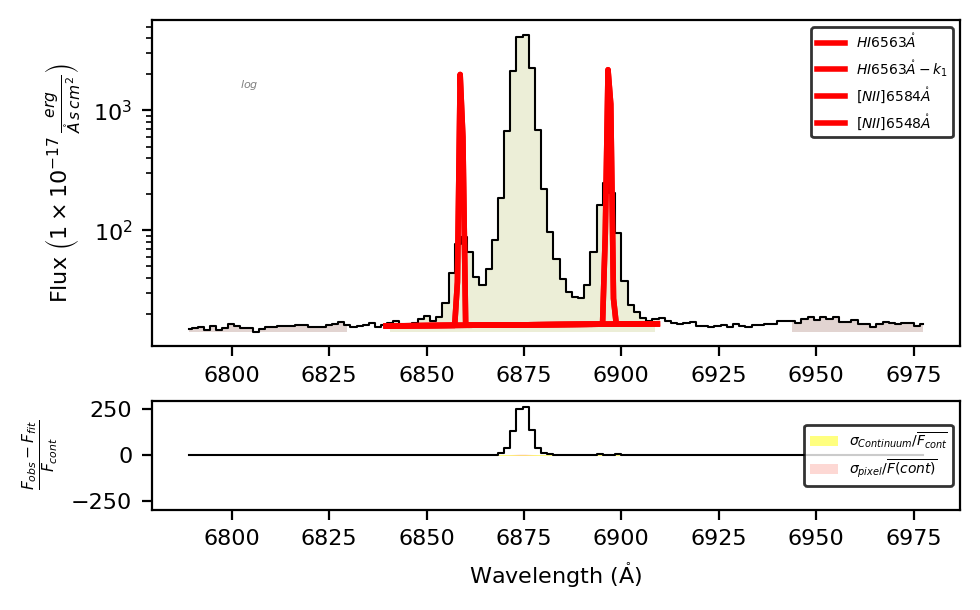

In [66]:
line = 'H1_6563A_b'
fit_conf = {'H1_6563A_b': 'H1_6563A+H1_6563A_k-1+N2_6584A+N2_6548A'} 
spec.fit.bands(line, band_df, fit_conf)
spec.plot.bands()

And the uncertainty of the profile components will be ``np.nan``:

In [67]:
spec.frame.loc[['H1_6563A', 'H1_6563A_k-1'], ['profile_flux', 'profile_flux_err', 'amp', 'amp_err', 'center', 'center_err', 'sigma', 'sigma_err']]

,profile_flux,profile_flux_err,amp,amp_err,center,center_err,sigma,sigma_err
H1_6563A,NaN,NaN,3287.101766,NaN,16599.399793,NaN,2.776036,NaN
H1_6563A_k-1,NaN,NaN,3287.101765,NaN,-2850.164256,NaN,2.776036,NaN


In order to fix a failed fitting, you can add more constrains on the parameters. In order to get a better insight on the causes behind the failed fitting you can access the [LmFIT report](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.ModelResult.fit_report) via the ``.fit.report()``:

In [68]:
spec.fit.report()

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 220
    # data points      = 93
    # variables        = 12
    chi-square         = 59785.1317
    reduced chi-square = 738.088046
    Akaike info crit   = 625.329889
    Bayesian info crit = 655.721083
    R-squared          = -0.05984133
##  Warning: uncertainties could not be estimated:
[[Variables]]
    H1_6563A_m_cont:  0.009730538 (fixed)
    H1_6563A_n_cont: -50.68299 (fixed)
    H1_6563A_amp:     3287.10177 (init = 4267.743)
    H1_6563A_center:  16599.3998 (init = 6874.448)
    H1_6563A_sigma:   2.77603640 (init = 3.165993)
    H1_6563A_k-1_amp:     3287.10177 (init = 4267.743)
    H1_6563A_k-1_center: -2850.16426 (init = 6874.448)
    H1_6563A_k-1_sigma:   2.77603640 (init = 3.165993)
    N2_6584A_amp:     2715.41412 (init = 4267.743)
    N2_6584A_center:  6896.82095 (init = 6896.74)
    N2_6584A_sigma:   0.35109019 (init = 3.165993)
    N2_6548A_amp:     2519.56953 (init = 4267.743)
    N2_65

We can see in this report that there is a big change between the initial center for the Halpha components:

```
H1_6563A_center:  16599.3998 (init = 6874.448)
H1_6563A_k-1_center: -2850.16426 (init = 6874.448)
```

This means that you should constrain these parameters more.

<div class="alert alert-info">

**Please remember:** Once we start to fit profiles with more than 10 dimensions (four Gaussian components) tranditional minimizers are very sensitive to the boundary conditions and cannot explore the parameter space efficiently. Future $\mathrm{LiMe}$ upgrades will explore more advance samplers to automatically decide the number of components and estimate the parameter values distributions.
</div>

## Read fitting configuration from a text file

In most cases, you will be interested in fitting multiple lines from multiple spectra. In order to simplify the configuration entries typing, it is recomended that you put your configuration into a text file with a [.toml configuration format](https://toml.io/en/) and use that as an input for your ``.fit`` functions.

For example, lets save the previous configuration to a text file:

In [69]:
fit_cfg_str = """[default_line_fitting]
H1_6563A_b = 'H1_6563A+H1_6563A_k-1+N2_6584A+N2_6548A'
N2_6548A_amp = 'expr:N2_6584A_amp/2.94'
N2_6548A_kinem = 'N2_6584A'
H1_6563A_k-1_center = 'value:6562,min:6561,max:6563'
H1_6563A_k-1_sigma = 'expr:>1.0*H1_6563A_sigma'
"""

# Save to file while keeping line breaks
with open("Halpha_cfg.toml", "w", encoding="utf-8") as file:
    file.write(fit_cfg_str)

This produces a '.toml' file which can be read using $\tt{lime.load\_cfg}$ function:

In [70]:
fit_cfg = lime.load_cfg("Halpha_cfg.toml")
fit_cfg

{'default_line_fitting': {'H1_6563A_b': 'H1_6563A+H1_6563A_k-1+N2_6584A+N2_6548A',
  'N2_6548A_amp': {'expr': 'N2_6584A_amp/2.94'},
  'N2_6548A_kinem': 'N2_6584A',
  'H1_6563A_k-1_center': {'value': 6562.0, 'min': 6561.0, 'max': 6563.0},
  'H1_6563A_k-1_sigma': {'expr': '>1.0*H1_6563A_sigma'}}}

When the $\tt{lime.load\_cfg}$ function finds a ``[section]`` with the ``_line_fitting`` it will format the entries to match $\mathrm{LiMe}$ expected ittin format. This way you don't need to type the **"{"** and **"}"** characters (but you must avoid white spaces and put all the item values between **' '**). 

This dictionary can be introduced to the fitting function directly:

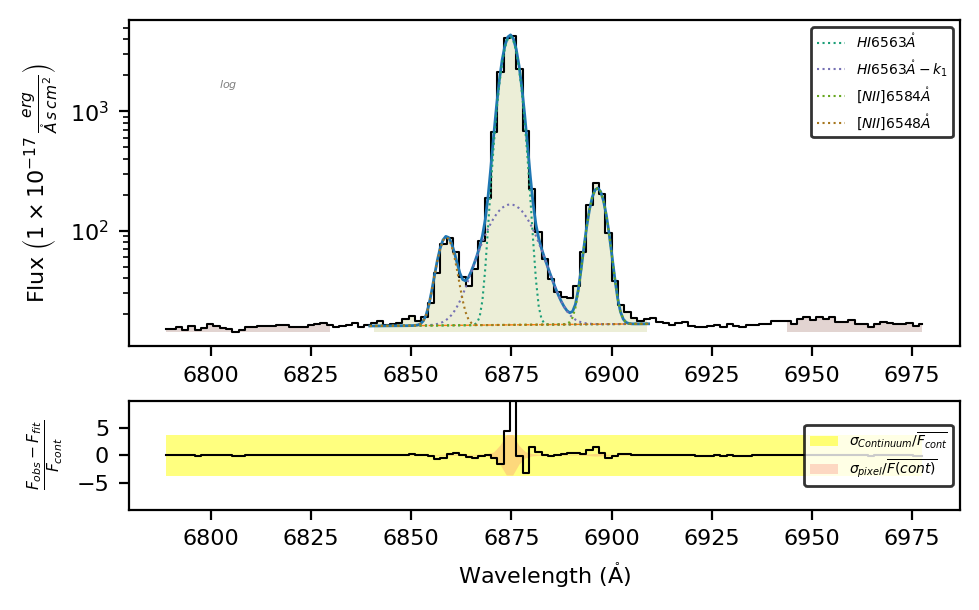

In [71]:
line = 'H1_6563A_b'
spec.fit.bands(line, band_df, fit_cfg)
spec.plot.bands()

Or we can directly input the text file address:

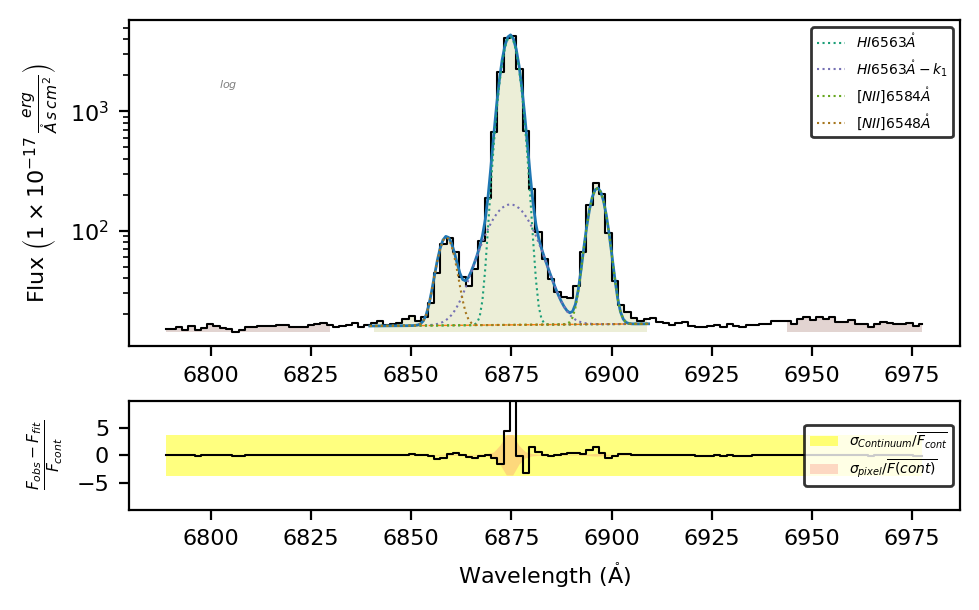

In [72]:
line = 'H1_6563A_b'
spec.fit.bands(line, band_df, "Halpha_cfg.toml")
spec.plot.bands()

## Save the results

$\mathrm{LiMe}$ can save the results into different formats using the $\tt{lime.Spectrum.save\_frame}$ function:

In [76]:
# Save to a text file
spec.save_frame('../sample_data/example1_linelog.txt')

Additional file formats allow the user to save the current data to a specific page:

In [81]:
spec.save_frame('../sample_data/example1_linelog.fits', page='SHOC579')
spec.save_frame('../sample_data/example1_linelog.xlsx', page='SHOC579')

Finally, if you have latex and pylatex installed on your system you can also save the results as a pdf file:

In [82]:
spec.save_frame('../sample_data/example1_linelog.pdf', param_list=['eqw', 'profile_flux', 'profile_flux_err'])

The argument ``param_list`` constrains the output measurements to the input list.

## Takeaways

* By default $\mathrm{LiMe}$ will fit a Gaussian profile to a line.
* To fit multiple components to a line you need to add the blended suffix to the line label (for example ``H1_6563A_b``) and its components into the fitting configuration: (for example ``H1_6563A_b='H1_6563A+N2_6585A+N2_6548A'``)
* You can constrain the components profile parameter using the value,min,max,expr,vary attributes to the configuration (for example ``'expr:>1.0*H1_6563A_sigma'``)
* In very complex profiles (4 components or more) the minimizer is very sensitive to the input boundary conditions a lot of tinkering might be necessary in the current algorithm version to succesfully fit these profiles.
* It is recomended you save your profile settings in a .toml file and input them on the fitting functions. As long as the corresponding ``[section]`` has the ``_line_fitting`` suffix the entries will be formated to the expected format. If no section name is introduced $\mathrm{LiMe}$ will use the data from the ``[default_line_fitting]``